# Metrics of Fine tuning Clus-Replica with augmented images

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np

import sys
sys.path.insert(0, "./../../../src/utils/")
from utils import winapi_path

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
data_dir = "./../../../data/model_learning/"
scores_dir = data_dir + "scores/"
losses_dir = data_dir + "losses/"
lr_dir = data_dir + "learning_rates/"

scores_folder = "scores_lst-resnext-101_280_batch-4_adam_e-6_steplr_10-0.1_Marg-0.7_triplets-10_with-aug-images_noaugintest"
losses_folder = "losses_lst-resnext-101_280_batch-4_adam_e-6_steplr_10-0.1_Marg-0.7_triplets-10_with-aug-images_noaugintest"
lr_folder = "lr_lst-resnext-101_280_batch-4_adam_e-6_steplr_10-0.1_Marg-0.7_triplets-10_with-aug-images_noaugintest"
train_param = "Clus-Replica Resnext-101, 280 res, Batch 4, adam_e-6, steplr_10-0.1, Loss Marg-0.7, 10 triplets, with aug images"

In [2]:
def read_losses_scores_lr(curr_losses_folder, curr_scores_folder, curr_lr_folder, split_id):
    
    if split_id:
        curr_scores_folder = curr_scores_folder + "_v" + str(split_id) + "/"
        curr_losses_folder = curr_losses_folder + "_v" + str(split_id) + "/"
        curr_lr_folder = curr_lr_folder + "_v" + str(split_id) + "/"
    else:    
        curr_scores_folder = curr_scores_folder + "/"
        curr_losses_folder = curr_losses_folder + "/"
        curr_lr_folder = curr_lr_folder + "/"
        
    
    train_loss = pd.read_csv(winapi_path(losses_dir + curr_losses_folder + "train_loss.csv"))
    val_loss = pd.read_csv(winapi_path(losses_dir + curr_losses_folder + "validation_loss.csv"))


    train_scores = pd.read_csv(winapi_path(scores_dir + curr_scores_folder + "train_scores.csv"))
    val_scores = pd.read_csv(winapi_path(scores_dir + curr_scores_folder + "validation_scores.csv"))
    test_scores = pd.read_csv(winapi_path(scores_dir + curr_scores_folder + "test_scores.csv"))
    non_train_scores = pd.read_csv(winapi_path(scores_dir + curr_scores_folder + "test-and-val_scores.csv"))
    
    learning_rates = pd.read_csv(winapi_path(lr_dir + curr_lr_folder + "learning_rate.csv"))
    
    return train_loss, val_loss, train_scores, val_scores, test_scores, non_train_scores, learning_rates


def highlight_df_scores(score_df):
    return (score_df.style.highlight_min(color = 'lightgreen', axis = 0, subset=['mean_position','mean_min_position', 'mean_median_position'])
 .highlight_max(color = 'lightblue', axis = 0, subset=['map','recall_400', 'recall_200', 'recall_100', 'recall_50', 'recall_20']))


def plot_mean_position(train_df, val_df, test_df, test_val_df, train_param):
    plts = plt.figure(figsize=(9, 6))
    plt.plot(train_df['mean_position'], label="train")
    if val_df is not None:
        plt.plot(val_df['mean_position'], label="validation")
    if test_df is not None:
        plt.plot(test_df['mean_position'], label="test")
    if test_val_df is not None:
        plt.plot(test_val_df['mean_position'], label="Non-Train")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Position of retrived artwork")
    plt.legend()
    plt.title("Average position of the expected artwork in the list of retrived artworks")
    plt.suptitle(train_param)
    plt.grid()
    plts.tight_layout()
    
    
def plot_recall_at_k(train_df, val_df, test_df, test_val_df, train_param, recall_columns = ['recall_400', 'recall_200', 'recall_100', 'recall_50', 'recall_20']):

    plts = plt.figure(figsize=(15, 9))
    ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=plts)
    ax2 = plt.subplot2grid((2,6), (0,2), colspan=2, fig=plts, sharey=ax1)
    ax3 = plt.subplot2grid((2,6), (0,4), colspan=2, fig=plts, sharey=ax1)
    ax4 = plt.subplot2grid((2,6), (1,1), colspan=2, fig=plts, sharey=ax1)
    ax5 = plt.subplot2grid((2,6), (1,3), colspan=2, fig=plts, sharey=ax1)

    axs = [ax1, ax2, ax3, ax4, ax5]

    for num, name in enumerate(recall_columns):

        axs[num].plot(train_df[name], label="train")
        axs[num].plot(val_df[name], label="validation")
        axs[num].plot(test_df[name], label="test")
        if test_val_df is not None:
            axs[num].plot(test_val_df[name], label="non-train")
        axs[num].set_xlabel("Epoch")
        axs[num].set_ylabel(name)
        axs[num].legend()
        axs[num].set_title(name.replace("_", "@").replace("recall", "Recall"))
        axs[num].grid()
        axs[num].xaxis.set_major_locator(MaxNLocator(integer=True))


    plts.suptitle("{}\nRecall@k".format(train_param))
    plt.yticks(np.linspace(0, 1, 11))
    plt.margins(x=0.02)
    plts.tight_layout()
    
    
def get_averaged_df(score_dataframe):
    a = score_dataframe.groupby("model").agg(['mean', 'std'])
    a.columns = list(map('_'.join, a.columns.values))
    a["MP"] = round(a["MP_mean"], 2).astype(str) + " ± " + round(a["MP_std"], 2).astype(str)
    a["MMP"] = round(a["MMP_mean"], 2).astype(str) + " ± " + round(a["MMP_std"], 2).astype(str)
    a["mean_median_position"] = round(a["mean_median_position_mean"], 2).astype(str) + " ± " + round(a["mean_median_position_std"], 2).astype(str)
    a["MAP"] = round(a["MAP_mean"], 2).astype(str) + " ± " + round(a["MAP_std"], 2).astype(str)
    a["R@400"] = round(a["R@400_mean"], 2).astype(str) + " ± " + round(a["R@400_std"], 2).astype(str)
    a["R@200"] = round(a["R@200_mean"], 2).astype(str) + " ± " + round(a["R@200_std"], 2).astype(str)
    a["R@100"] = round(a["R@100_mean"], 2).astype(str) + " ± " + round(a["R@100_std"], 2).astype(str)
    a["R@50"] = round(a["R@50_mean"], 2).astype(str) + " ± " + round(a["R@50_std"], 2).astype(str)
    a["R@20"] = round(a["R@20_mean"], 2).astype(str) + " ± " + round(a["R@20_std"], 2).astype(str)

    b = a[["MP", "MMP", 'MAP','R@400', 'R@200', 'R@100', 'R@50', 'R@20']].reset_index()
    score_dataframe_avg_df = b.replace({"resnet": "ResNet-101", "resnext": "ResNeXT-101"})
    
    return score_dataframe_avg_df

In [4]:
train_metrics, val_metrics, test_metrics, non_train_metrics = [], [], [], []

## Data Split - v0

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,643.615789,768.401434,592.516129,0.199240,0.666667,0.571685,0.500000,0.422939,0.333333
1,279.754386,133.193548,269.369176,0.472233,0.913978,0.863799,0.822581,0.763441,0.663082
2,315.133333,226.193548,314.129032,0.489175,0.899642,0.845878,0.795699,0.724014,0.636201
3,756.391228,1087.448029,748.189964,0.314807,0.621864,0.582437,0.534050,0.476703,0.406810
4,1162.717544,1842.390681,1144.116487,0.198417,0.460573,0.410394,0.362007,0.329749,0.284946
5,1420.533333,2327.759857,1396.028674,0.149315,0.349462,0.304659,0.274194,0.238351,0.202509


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,664.000000,997.473684,678.105263,0.492562,0.736842,0.736842,0.684211,0.684211,0.684211
1,373.425000,384.157895,372.921053,0.423269,0.736842,0.736842,0.736842,0.684211,0.684211
2,321.425000,276.263158,317.447368,0.376982,0.736842,0.736842,0.736842,0.736842,0.631579
3,1013.075000,1731.736842,1045.710526,0.107391,0.578947,0.578947,0.421053,0.421053,0.315789
4,1452.400000,2653.368421,1509.315789,0.061090,0.315789,0.263158,0.210526,0.157895,0.105263
5,1775.350000,3334.105263,1849.210526,0.065265,0.210526,0.210526,0.157895,0.157895,0.105263


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,407.500000,251.263158,345.526316,0.335796,0.789474,0.684211,0.631579,0.578947,0.526316
1,397.900000,317.894737,379.894737,0.427006,0.736842,0.736842,0.736842,0.684211,0.631579
2,320.450000,128.736842,285.368421,0.348453,0.789474,0.789474,0.684211,0.684211,0.526316
3,878.900000,1301.578947,874.473684,0.129212,0.421053,0.421053,0.315789,0.315789,0.210526
4,1434.550000,2293.578947,1429.578947,0.140149,0.421053,0.315789,0.263158,0.263158,0.263158
5,1735.175000,2917.526316,1774.552632,0.050311,0.315789,0.263158,0.210526,0.210526,0.157895


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,535.750000,624.368421,511.815789,0.414179,0.763158,0.710526,0.657895,0.631579,0.605263
1,385.662500,351.026316,376.407895,0.425137,0.736842,0.736842,0.736842,0.684211,0.657895
2,320.937500,202.500000,301.407895,0.362718,0.763158,0.763158,0.710526,0.710526,0.578947
3,945.987500,1516.657895,960.092105,0.118302,0.500000,0.500000,0.368421,0.368421,0.263158
4,1443.475000,2473.473684,1469.447368,0.100619,0.368421,0.289474,0.236842,0.210526,0.184211
5,1755.262500,3125.815789,1811.881579,0.057788,0.263158,0.236842,0.184211,0.184211,0.131579


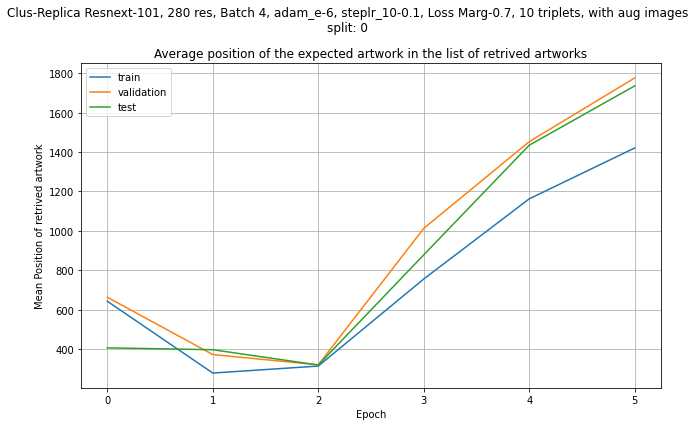

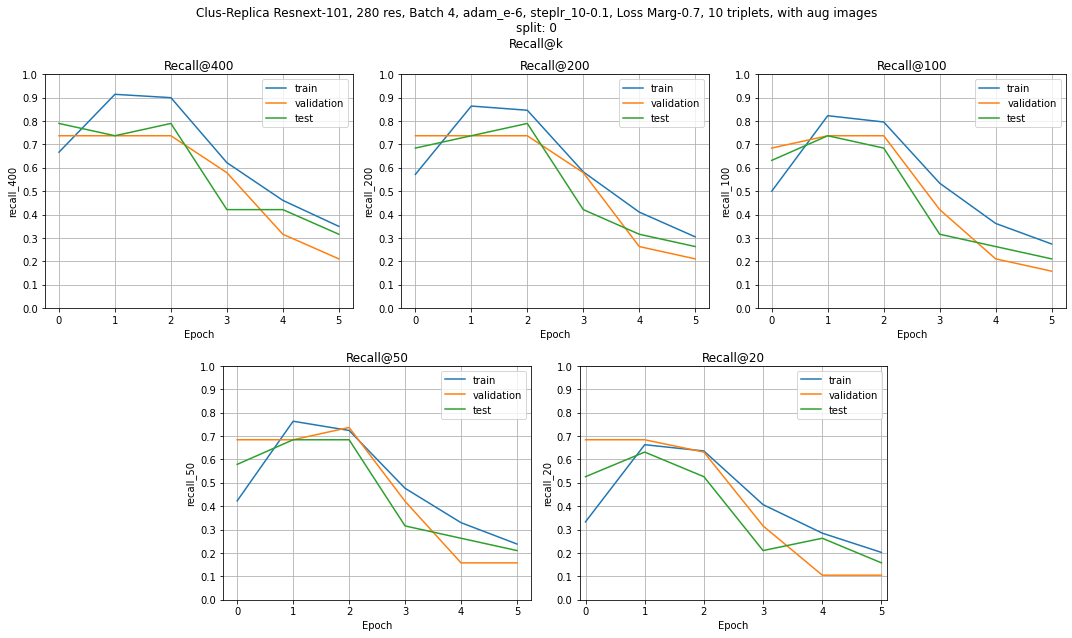

In [5]:
split_id = 0

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [6]:
best_epoch = 2

train_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v1

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,681.994048,782.037500,609.237500,0.235221,0.683333,0.593750,0.518750,0.456250,0.395833
1,311.102183,186.847917,289.669792,0.436881,0.883333,0.835417,0.812500,0.750000,0.639583
2,303.628968,214.308333,297.977083,0.456830,0.904167,0.854167,0.795833,0.720833,0.641667
3,515.729167,575.710417,500.196875,0.387399,0.739583,0.697917,0.658333,0.612500,0.552083
4,1090.481151,1754.606250,1093.626042,0.234853,0.506250,0.452083,0.389583,0.352083,0.320833
5,1207.856151,2025.506250,1223.676042,0.189322,0.420833,0.358333,0.320833,0.295833,0.258333


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,422.200000,444.400000,422.200000,0.235071,0.700000,0.633333,0.600000,0.533333,0.400000
1,400.083333,400.166667,400.083333,0.250751,0.833333,0.766667,0.666667,0.633333,0.400000
2,448.700000,497.400000,448.700000,0.213225,0.733333,0.700000,0.633333,0.500000,0.333333
3,493.600000,587.200000,493.600000,0.197033,0.533333,0.533333,0.466667,0.433333,0.300000
4,871.033333,1342.066667,871.033333,0.072727,0.433333,0.333333,0.300000,0.233333,0.200000
5,1213.800000,2027.600000,1213.800000,0.120879,0.300000,0.300000,0.233333,0.200000,0.200000


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,637.357143,874.714286,637.357143,0.261836,0.714286,0.666667,0.619048,0.571429,0.476190
1,466.190476,532.380952,466.190476,0.378424,0.761905,0.714286,0.714286,0.666667,0.571429
2,536.595238,673.190476,536.595238,0.269937,0.714286,0.666667,0.619048,0.571429,0.523810
3,437.238095,474.476190,437.238095,0.220249,0.714286,0.619048,0.476190,0.428571,0.333333
4,994.595238,1589.190476,994.595238,0.198056,0.619048,0.523810,0.428571,0.333333,0.190476
5,910.880952,1421.761905,910.880952,0.138023,0.476190,0.380952,0.333333,0.333333,0.285714


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,510.794118,621.588235,510.794118,0.246092,0.705882,0.647059,0.607843,0.549020,0.431373
1,427.303922,454.607843,427.303922,0.303323,0.803922,0.745098,0.686275,0.647059,0.470588
2,484.892157,569.784314,484.892157,0.236577,0.725490,0.686275,0.627451,0.529412,0.411765
3,470.392157,540.784314,470.392157,0.206593,0.607843,0.568627,0.470588,0.431373,0.313725
4,921.911765,1443.823529,921.911765,0.124333,0.509804,0.411765,0.352941,0.274510,0.196078
5,1089.068627,1778.137255,1089.068627,0.127938,0.372549,0.333333,0.274510,0.254902,0.235294


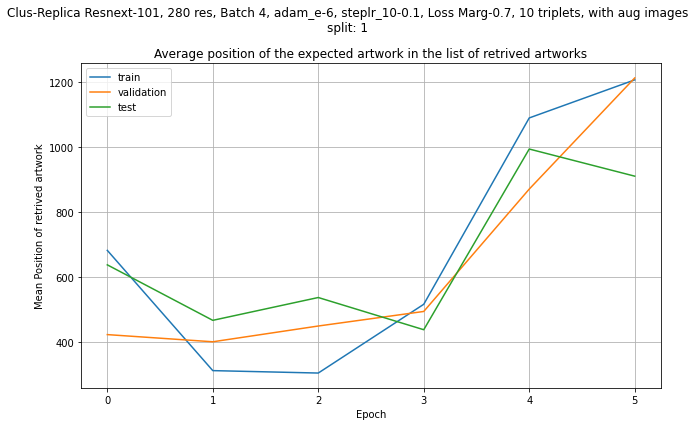

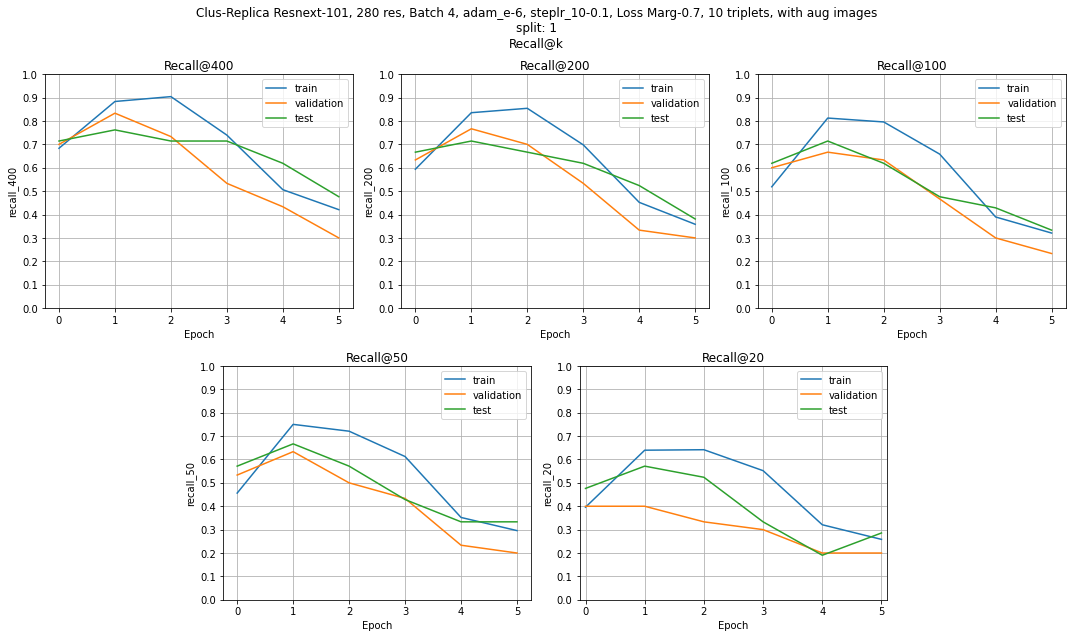

In [7]:
split_id = 1

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [8]:
best_epoch = 1

train_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v2

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,639.279412,750.900407,585.427846,0.240359,0.705285,0.605691,0.546748,0.483740,0.414634
1,277.041176,135.000000,264.313008,0.518804,0.918699,0.882114,0.851626,0.794715,0.717480
2,249.050000,106.095528,245.320122,0.624313,0.943089,0.926829,0.898374,0.863821,0.806911
3,323.037255,253.613821,322.583333,0.571414,0.896341,0.867886,0.831301,0.794715,0.735772
4,844.834314,1276.266260,837.145325,0.368086,0.650407,0.595528,0.550813,0.489837,0.447154
5,1503.696078,2589.955285,1498.491870,0.223859,0.410569,0.371951,0.347561,0.317073,0.286585


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,651.590909,903.181818,651.590909,0.244986,0.681818,0.590909,0.500000,0.454545,0.318182
1,508.340909,616.681818,508.340909,0.352426,0.772727,0.727273,0.636364,0.545455,0.454545
2,616.613636,833.227273,616.613636,0.346494,0.681818,0.681818,0.681818,0.545455,0.454545
3,503.295455,606.590909,503.295455,0.276808,0.727273,0.590909,0.454545,0.363636,0.318182
4,1112.568182,1825.136364,1112.568182,0.215848,0.454545,0.409091,0.363636,0.318182,0.272727
5,1821.931818,3243.863636,1821.931818,0.077009,0.363636,0.272727,0.227273,0.227273,0.181818


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,457.267857,403.000000,415.500000,0.209221,0.666667,0.629630,0.555556,0.481481,0.370370
1,386.071429,374.592593,398.555556,0.195511,0.740741,0.666667,0.592593,0.555556,0.444444
2,432.357143,461.481481,445.518519,0.199342,0.703704,0.666667,0.592593,0.555556,0.518519
3,463.410714,537.962963,477.277778,0.238269,0.666667,0.555556,0.481481,0.444444,0.333333
4,472.267857,577.370370,475.722222,0.154256,0.703704,0.666667,0.444444,0.407407,0.259259
5,934.017857,1532.925926,955.833333,0.146121,0.555556,0.444444,0.407407,0.296296,0.296296


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,542.770000,627.571429,521.500000,0.225279,0.673469,0.612245,0.530612,0.469388,0.346939
1,439.870000,483.285714,447.846939,0.265963,0.755102,0.693878,0.612245,0.551020,0.448980
2,513.430000,628.387755,522.336735,0.265410,0.693878,0.673469,0.632653,0.551020,0.489796
3,480.960000,568.775510,488.959184,0.255572,0.693878,0.571429,0.469388,0.408163,0.326531
4,754.000000,1137.591837,761.653061,0.181910,0.591837,0.551020,0.408163,0.367347,0.265306
5,1324.700000,2301.102041,1344.693878,0.115091,0.469388,0.367347,0.326531,0.265306,0.244898


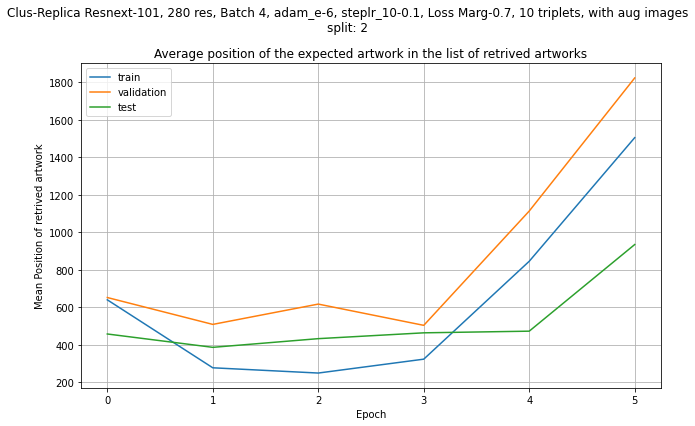

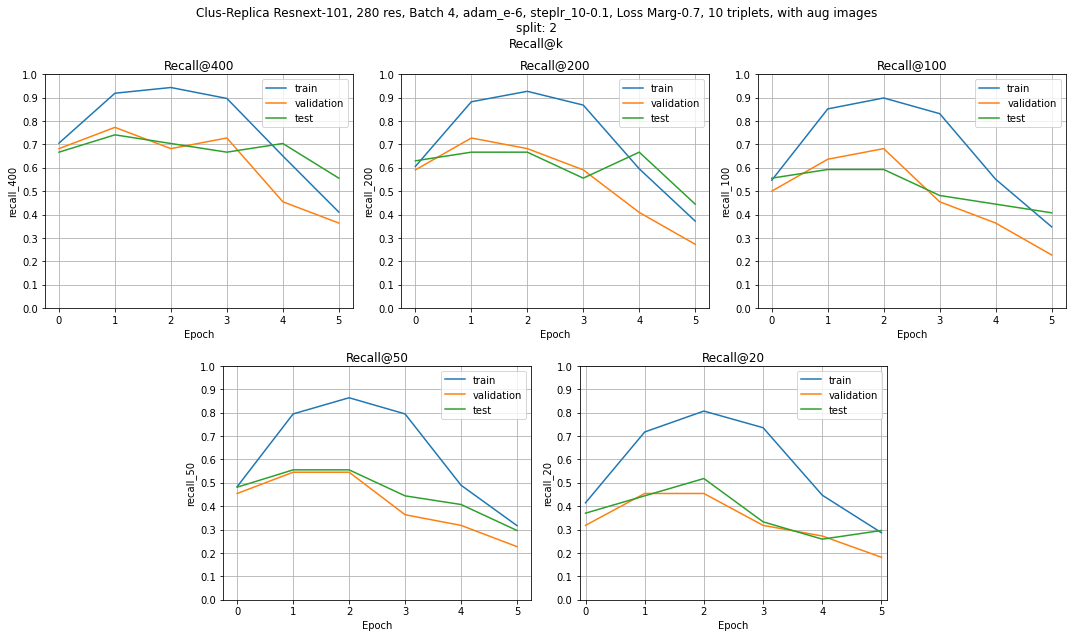

In [9]:
split_id = 2

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [10]:
best_epoch = 1

train_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v3

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,576.518162,759.205628,580.185065,0.265982,0.722944,0.634199,0.573593,0.515152,0.452381
1,264.514957,135.601732,262.880952,0.537593,0.922078,0.876623,0.826840,0.783550,0.714286
2,234.997863,75.878788,232.963203,0.657536,0.965368,0.935065,0.906926,0.870130,0.820346
3,280.375000,167.521645,279.066017,0.621106,0.904762,0.874459,0.837662,0.800866,0.748918
4,471.714744,532.716450,464.187229,0.456019,0.777056,0.716450,0.664502,0.623377,0.571429


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,493.283333,548.103448,486.982759,0.165422,0.620690,0.586207,0.482759,0.413793,0.275862
1,429.550000,477.827586,435.948276,0.180332,0.655172,0.620690,0.517241,0.482759,0.379310
2,362.600000,341.517241,365.275862,0.175087,0.758621,0.724138,0.620690,0.482759,0.379310
3,496.850000,613.344828,506.879310,0.174359,0.655172,0.517241,0.448276,0.448276,0.379310
4,541.666667,706.896552,549.896552,0.069251,0.482759,0.310345,0.206897,0.206897,0.206897


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,724.888889,615.440000,526.600000,0.280179,0.720000,0.600000,0.560000,0.480000,0.360000
1,678.814815,473.200000,461.960000,0.383235,0.800000,0.720000,0.680000,0.600000,0.520000
2,689.833333,521.320000,475.900000,0.376710,0.880000,0.760000,0.640000,0.600000,0.520000
3,597.407407,582.240000,511.920000,0.198790,0.840000,0.720000,0.520000,0.480000,0.280000
4,995.500000,1008.360000,801.460000,0.122638,0.360000,0.200000,0.160000,0.160000,0.120000


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,602.991228,579.277778,505.324074,0.218550,0.666667,0.592593,0.518519,0.444444,0.314815
1,547.622807,475.685185,447.990741,0.274269,0.722222,0.666667,0.592593,0.537037,0.444444
2,517.605263,424.759259,416.490741,0.268431,0.814815,0.740741,0.629630,0.537037,0.444444
3,544.482456,598.944444,509.212963,0.185670,0.740741,0.611111,0.481481,0.462963,0.333333
4,756.640351,846.462963,666.361111,0.093967,0.425926,0.259259,0.185185,0.185185,0.166667


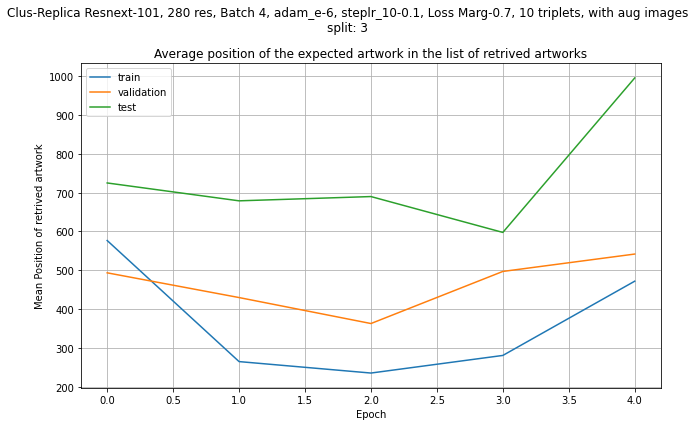

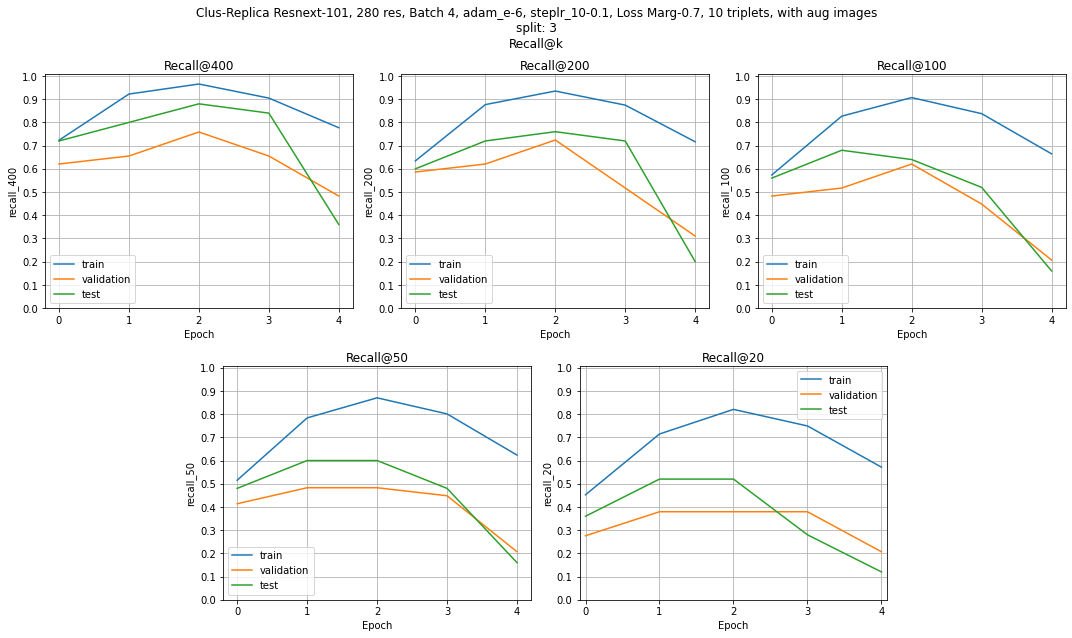

In [11]:
split_id = 3

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [12]:
best_epoch = 2

train_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v4

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,661.100402,824.596708,619.897119,0.239519,0.699588,0.600823,0.532922,0.465021,0.405350
1,300.467871,162.283951,281.862140,0.471257,0.907407,0.862140,0.812757,0.759259,0.662551
2,281.620482,131.666667,266.524691,0.550513,0.915638,0.888889,0.849794,0.798354,0.740741
3,785.747992,1135.771605,770.015432,0.367301,0.652263,0.615226,0.582305,0.534979,0.467078
4,885.436747,1334.393004,878.622428,0.210126,0.522634,0.452675,0.407407,0.360082,0.316872


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,542.000000,589.266667,507.233333,0.177105,0.700000,0.633333,0.600000,0.500000,0.333333
1,472.306452,544.500000,485.583333,0.227801,0.733333,0.700000,0.633333,0.566667,0.433333
2,447.693548,478.700000,452.650000,0.218321,0.766667,0.666667,0.666667,0.433333,0.366667
3,574.758065,775.366667,586.783333,0.200074,0.666667,0.633333,0.533333,0.433333,0.266667
4,900.193548,1266.200000,895.566667,0.111076,0.366667,0.300000,0.266667,0.233333,0.200000


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,466.380952,474.300000,455.900000,0.283993,0.650000,0.650000,0.600000,0.550000,0.450000
1,338.500000,294.750000,341.625000,0.291592,0.800000,0.800000,0.600000,0.550000,0.400000
2,405.428571,440.300000,409.400000,0.330950,0.750000,0.750000,0.650000,0.600000,0.400000
3,749.833333,1146.350000,772.075000,0.181751,0.600000,0.450000,0.350000,0.250000,0.250000
4,1134.666667,1588.600000,1126.650000,0.146384,0.500000,0.450000,0.350000,0.350000,0.350000


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,511.461538,543.280000,486.700000,0.219860,0.680000,0.640000,0.600000,0.520000,0.380000
1,418.269231,444.600000,428.000000,0.253318,0.760000,0.740000,0.620000,0.560000,0.420000
2,430.625000,463.340000,435.350000,0.263373,0.760000,0.700000,0.660000,0.500000,0.380000
3,645.461538,923.760000,660.900000,0.192745,0.640000,0.560000,0.460000,0.360000,0.260000
4,994.884615,1395.160000,988.000000,0.125199,0.420000,0.360000,0.300000,0.280000,0.260000


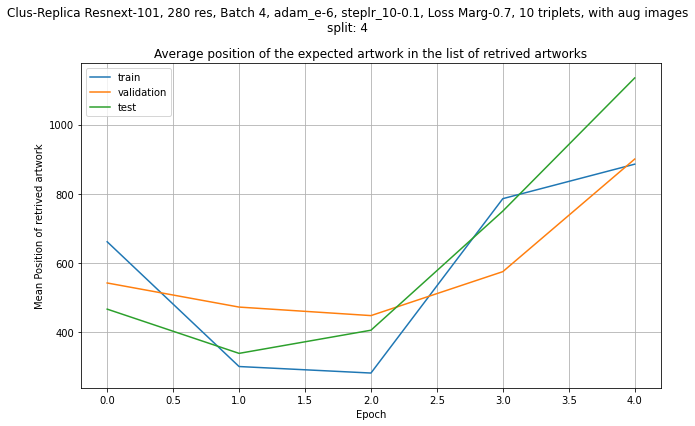

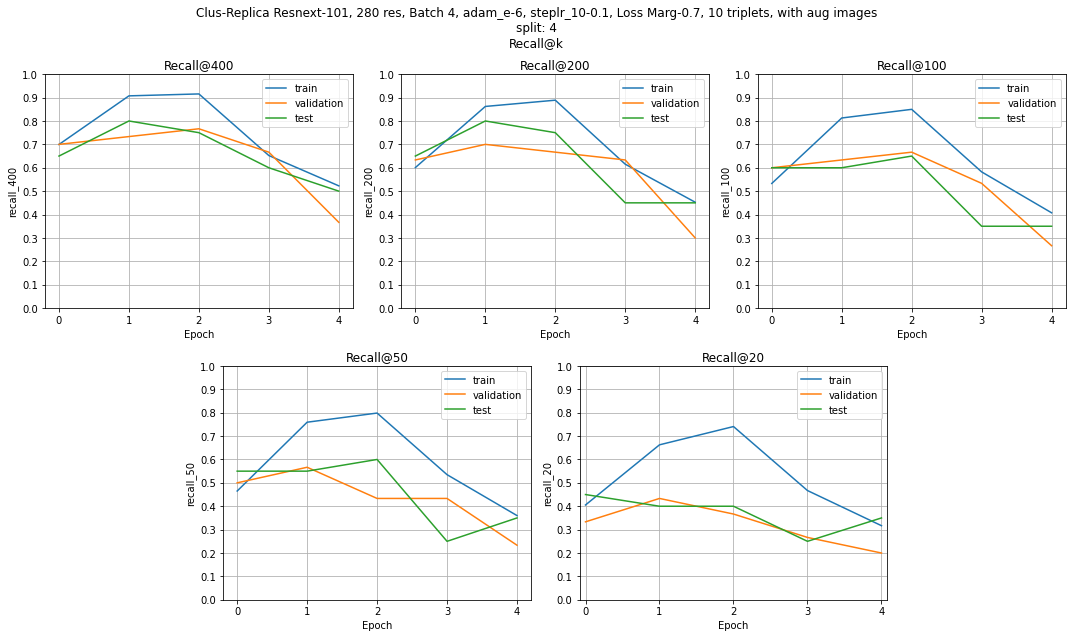

In [13]:
split_id = 4

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [14]:
best_epoch = 2

train_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v5

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,708.878876,896.668675,658.191767,0.221836,0.666667,0.570281,0.506024,0.445783,0.373494
1,319.171512,212.708835,304.444779,0.413833,0.883534,0.823293,0.763052,0.708835,0.622490
2,281.952519,148.074297,269.201807,0.494996,0.905622,0.867470,0.821285,0.775100,0.698795
3,389.553295,334.018072,372.822289,0.418026,0.829317,0.775100,0.712851,0.672691,0.592369
4,823.252907,1143.447791,792.952811,0.218418,0.580321,0.500000,0.449799,0.403614,0.337349
5,837.831395,1162.293173,799.212851,0.245664,0.578313,0.508032,0.459839,0.419679,0.357430


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,384.931034,369.862069,384.931034,0.236553,0.724138,0.655172,0.586207,0.482759,0.413793
1,371.275862,342.551724,371.275862,0.305209,0.793103,0.758621,0.655172,0.586207,0.517241
2,346.396552,292.793103,346.396552,0.343509,0.827586,0.758621,0.724138,0.689655,0.620690
3,367.155172,334.310345,367.155172,0.120340,0.827586,0.724138,0.551724,0.448276,0.344828
4,1212.172414,2024.344828,1212.172414,0.082021,0.551724,0.379310,0.275862,0.206897,0.137931
5,1309.810345,2219.620690,1309.810345,0.076912,0.379310,0.275862,0.241379,0.137931,0.103448


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,489.375000,423.631579,431.710526,0.381864,0.789474,0.631579,0.631579,0.631579,0.526316
1,312.725000,250.052632,312.289474,0.537110,0.736842,0.736842,0.736842,0.684211,0.631579
2,265.675000,154.473684,260.815789,0.475862,0.842105,0.736842,0.736842,0.736842,0.631579
3,464.875000,541.842105,486.710526,0.282225,0.578947,0.526316,0.473684,0.368421,0.368421
4,1018.225000,1727.000000,1058.868421,0.227208,0.526316,0.526316,0.421053,0.368421,0.315789
5,1003.825000,1598.263158,1000.552632,0.194095,0.526316,0.473684,0.473684,0.368421,0.263158


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,427.561224,391.145833,403.447917,0.294072,0.750000,0.645833,0.604167,0.541667,0.458333
1,347.377551,305.937500,347.927083,0.397003,0.770833,0.750000,0.687500,0.625000,0.562500
2,313.448980,238.041667,312.520833,0.395898,0.833333,0.750000,0.729167,0.708333,0.625000
3,407.040816,416.458333,414.479167,0.184420,0.729167,0.645833,0.520833,0.416667,0.354167
4,1133.010204,1906.645833,1151.489583,0.139491,0.541667,0.437500,0.333333,0.270833,0.208333
5,1184.918367,1973.666667,1187.395833,0.123297,0.437500,0.354167,0.333333,0.229167,0.166667


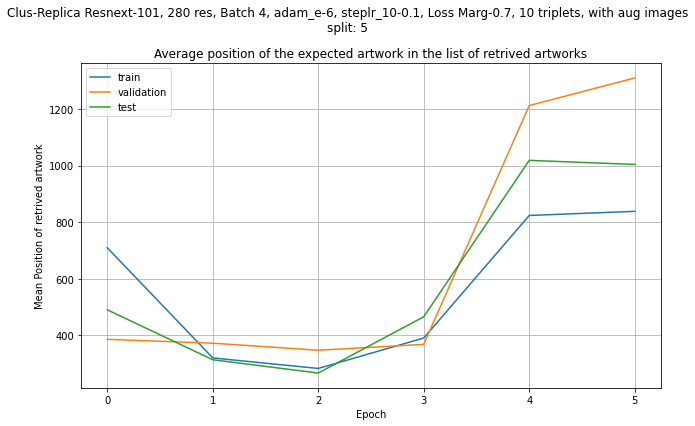

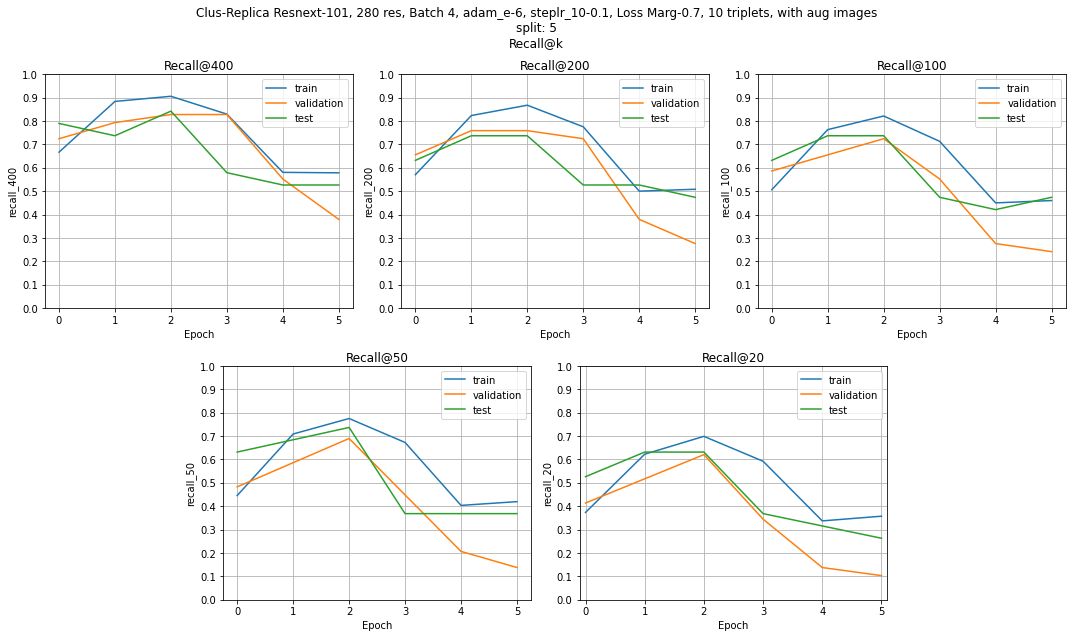

In [15]:
split_id = 5

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [16]:
best_epoch = 2

train_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v6

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,631.083333,775.450000,598.250000,0.273931,0.706250,0.631250,0.575000,0.529167,0.439583
1,305.751016,213.927083,301.236458,0.518722,0.902083,0.870833,0.825000,0.766667,0.706250
2,266.725610,138.945833,263.312500,0.597193,0.945833,0.914583,0.889583,0.843750,0.781250
3,350.603659,309.312500,351.495833,0.471490,0.862500,0.797917,0.735417,0.689583,0.631250
4,887.095528,1356.291667,883.464583,0.322358,0.620833,0.575000,0.531250,0.491667,0.439583


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,662.075000,524.611111,445.750000,0.260892,0.722222,0.555556,0.555556,0.555556,0.500000
1,557.975000,208.166667,305.805556,0.371699,0.722222,0.666667,0.611111,0.611111,0.500000
2,602.000000,209.444444,311.666667,0.314262,0.722222,0.666667,0.666667,0.500000,0.500000
3,737.725000,654.833333,523.861111,0.169096,0.611111,0.611111,0.555556,0.333333,0.333333
4,1246.475000,1946.611111,1162.638889,0.121411,0.444444,0.333333,0.277778,0.222222,0.166667


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,489.848485,579.696970,489.848485,0.243671,0.757576,0.666667,0.545455,0.424242,0.333333
1,479.984848,559.969697,479.984848,0.306742,0.787879,0.696970,0.636364,0.606061,0.454545
2,609.030303,818.060606,609.030303,0.230486,0.696970,0.666667,0.636364,0.606061,0.333333
3,855.196970,1310.393939,855.196970,0.222167,0.575758,0.484848,0.424242,0.393939,0.303030
4,1121.030303,1842.060606,1121.030303,0.223938,0.545455,0.484848,0.454545,0.393939,0.363636


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,554.839623,560.254902,474.284314,0.249749,0.745098,0.627451,0.549020,0.470588,0.392157
1,509.415094,435.803922,418.509804,0.329668,0.764706,0.686275,0.627451,0.607843,0.470588
2,606.377358,603.254902,504.078431,0.260054,0.705882,0.666667,0.647059,0.568627,0.392157
3,810.867925,1079.019608,738.254902,0.203436,0.588235,0.529412,0.470588,0.372549,0.313725
4,1168.367925,1878.960784,1135.715686,0.187752,0.509804,0.431373,0.392157,0.333333,0.294118


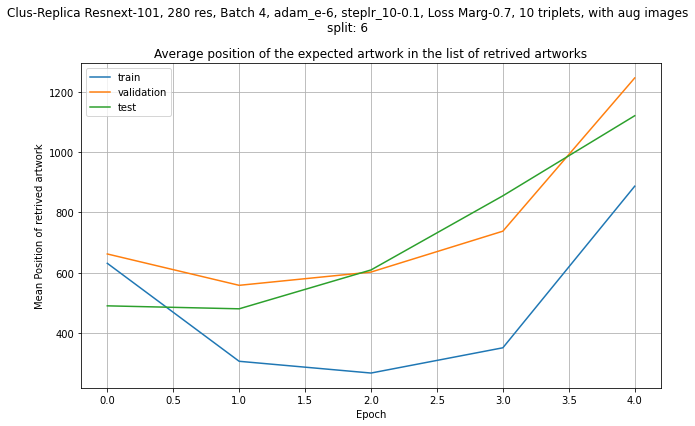

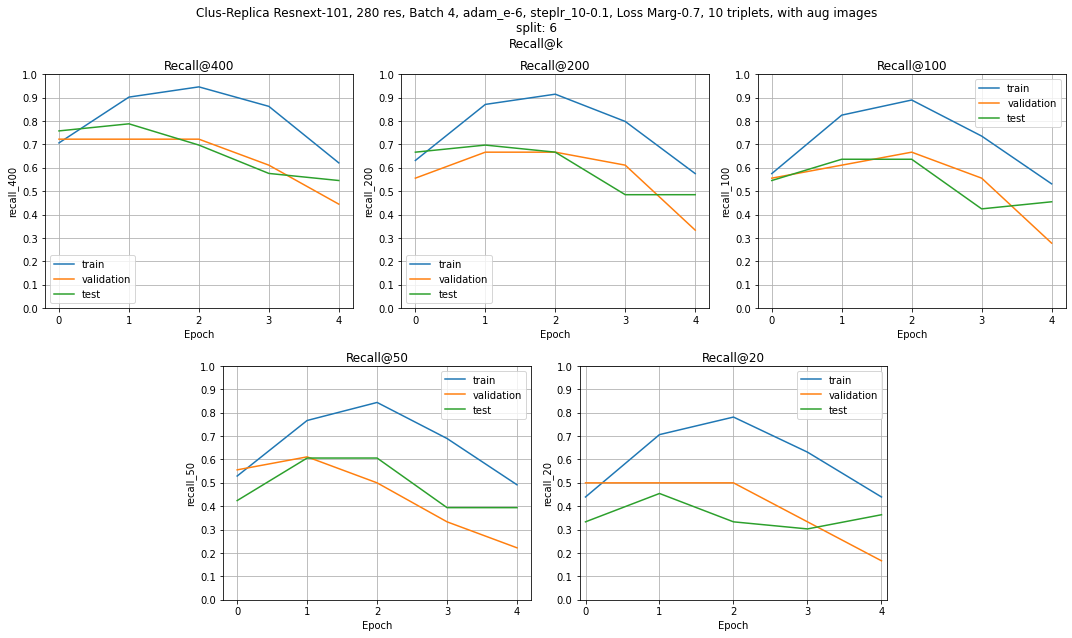

In [17]:
split_id = 6

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [18]:
best_epoch = 1

train_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v7

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,558.491228,639.265233,528.686380,0.216122,0.700717,0.607527,0.543011,0.458781,0.372760
1,247.650877,92.935484,242.324373,0.540775,0.939068,0.910394,0.867384,0.838710,0.758065
2,257.672807,124.754480,255.327061,0.574564,0.935484,0.912186,0.883513,0.853047,0.775986
3,505.772807,606.521505,503.594086,0.414997,0.734767,0.688172,0.637993,0.594982,0.553763
4,744.308772,1039.788530,736.259857,0.366017,0.641577,0.594982,0.535842,0.491039,0.460573


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,817.473684,1234.947368,817.473684,0.285107,0.578947,0.526316,0.526316,0.473684,0.421053
1,622.184211,844.368421,622.184211,0.300739,0.631579,0.578947,0.578947,0.473684,0.421053
2,589.157895,778.315789,589.157895,0.291373,0.684211,0.578947,0.578947,0.473684,0.421053
3,1296.631579,2193.263158,1296.631579,0.134325,0.473684,0.368421,0.210526,0.157895,0.157895
4,1368.789474,2337.578947,1368.789474,0.163528,0.526316,0.315789,0.263158,0.210526,0.210526


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,777.642857,801.105263,584.868421,0.406776,0.736842,0.631579,0.631579,0.631579,0.578947
1,718.166667,489.842105,448.605263,0.447795,0.736842,0.736842,0.736842,0.736842,0.684211
2,750.571429,857.894737,647.473684,0.294665,0.736842,0.736842,0.684211,0.578947,0.473684
3,1044.380952,1531.052632,954.473684,0.178657,0.473684,0.315789,0.315789,0.210526,0.210526
4,1118.238095,1834.947368,1149.000000,0.118642,0.368421,0.368421,0.263158,0.263158,0.157895


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,796.562500,1018.026316,701.171053,0.345942,0.657895,0.578947,0.578947,0.552632,0.500000
1,672.575000,667.105263,535.394737,0.374267,0.684211,0.657895,0.657895,0.605263,0.552632
2,673.900000,818.105263,618.315789,0.293019,0.710526,0.657895,0.631579,0.526316,0.447368
3,1164.200000,1862.157895,1125.552632,0.156491,0.473684,0.342105,0.263158,0.184211,0.184211
4,1237.250000,2086.263158,1258.894737,0.141085,0.447368,0.342105,0.263158,0.236842,0.184211


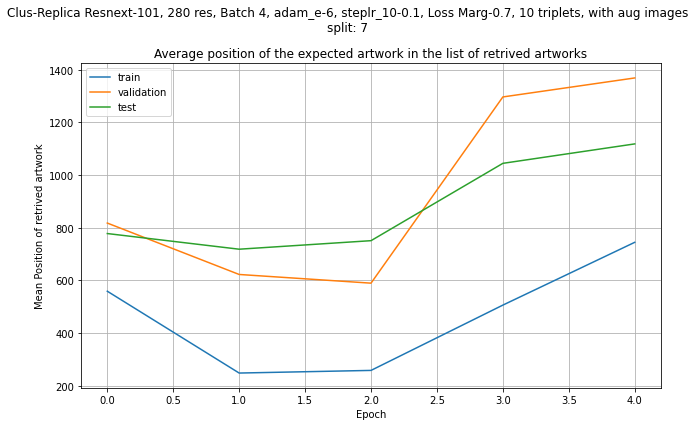

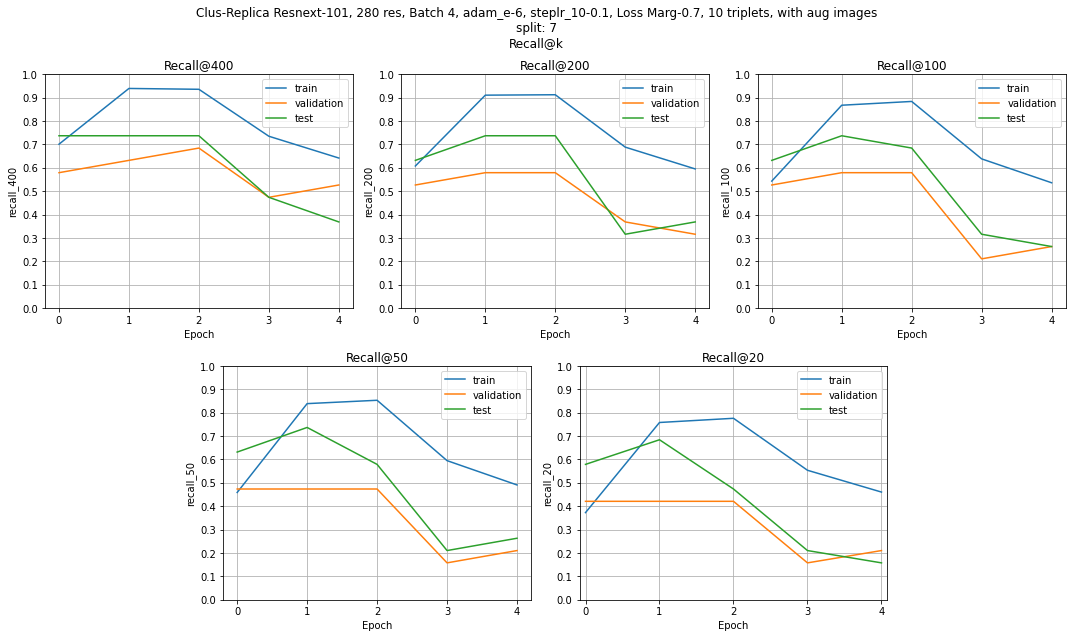

In [19]:
split_id = 7

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [20]:
best_epoch = 2

train_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v8

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,594.749031,710.327309,565.848394,0.244504,0.702811,0.608434,0.540161,0.477912,0.401606
1,267.078488,132.508032,257.067269,0.485776,0.927711,0.903614,0.841365,0.779116,0.686747
2,236.641473,86.622490,231.485944,0.561254,0.951807,0.933735,0.887550,0.837349,0.771084
3,325.747093,268.006024,326.197791,0.460241,0.851406,0.795181,0.746988,0.690763,0.616466
4,833.507752,1264.554217,839.315261,0.298976,0.588353,0.536145,0.493976,0.447791,0.401606
5,1039.158915,1673.305221,1047.702811,0.249914,0.524096,0.469880,0.421687,0.391566,0.343373


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,695.693548,710.033333,558.150000,0.199919,0.600000,0.500000,0.433333,0.366667,0.300000
1,565.741935,378.133333,402.366667,0.336350,0.733333,0.600000,0.600000,0.533333,0.500000
2,527.080645,372.633333,399.550000,0.292714,0.733333,0.700000,0.600000,0.566667,0.500000
3,565.274194,469.100000,446.316667,0.205020,0.766667,0.733333,0.600000,0.466667,0.366667
4,1299.451613,2054.666667,1239.566667,0.114187,0.466667,0.433333,0.433333,0.266667,0.200000
5,1431.451613,2305.200000,1365.600000,0.092525,0.366667,0.366667,0.333333,0.333333,0.266667


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,538.666667,677.333333,538.666667,0.347305,0.888889,0.722222,0.722222,0.666667,0.555556
1,524.305556,648.611111,524.305556,0.265106,0.722222,0.722222,0.611111,0.555556,0.500000
2,468.833333,537.666667,468.833333,0.237974,0.722222,0.666667,0.611111,0.500000,0.500000
3,626.055556,852.111111,626.055556,0.242262,0.611111,0.555556,0.500000,0.444444,0.388889
4,1436.416667,2472.833333,1436.416667,0.093716,0.444444,0.388889,0.277778,0.277778,0.166667
5,1492.000000,2584.000000,1492.000000,0.087523,0.388889,0.333333,0.277778,0.222222,0.111111


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,638.010204,697.770833,550.843750,0.255189,0.708333,0.583333,0.541667,0.479167,0.395833
1,550.520408,479.562500,448.093750,0.309634,0.729167,0.645833,0.604167,0.541667,0.500000
2,505.683673,434.520833,425.531250,0.272186,0.729167,0.687500,0.604167,0.541667,0.500000
3,587.602041,612.729167,513.718750,0.218986,0.708333,0.666667,0.562500,0.458333,0.375000
4,1349.765306,2211.479167,1313.385417,0.106511,0.458333,0.416667,0.375000,0.270833,0.187500
5,1453.693878,2409.750000,1413.000000,0.090649,0.375000,0.354167,0.312500,0.291667,0.208333


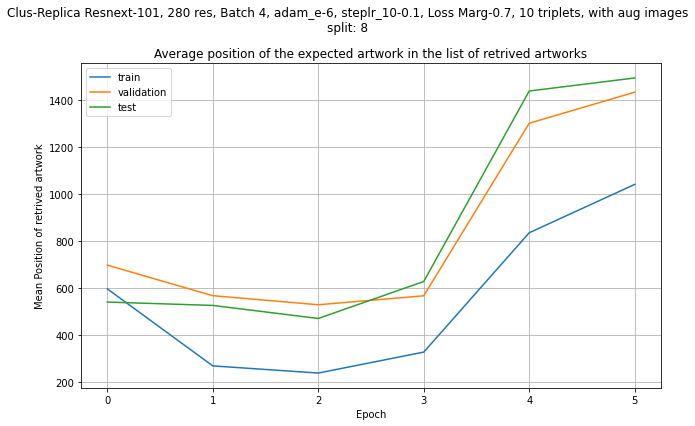

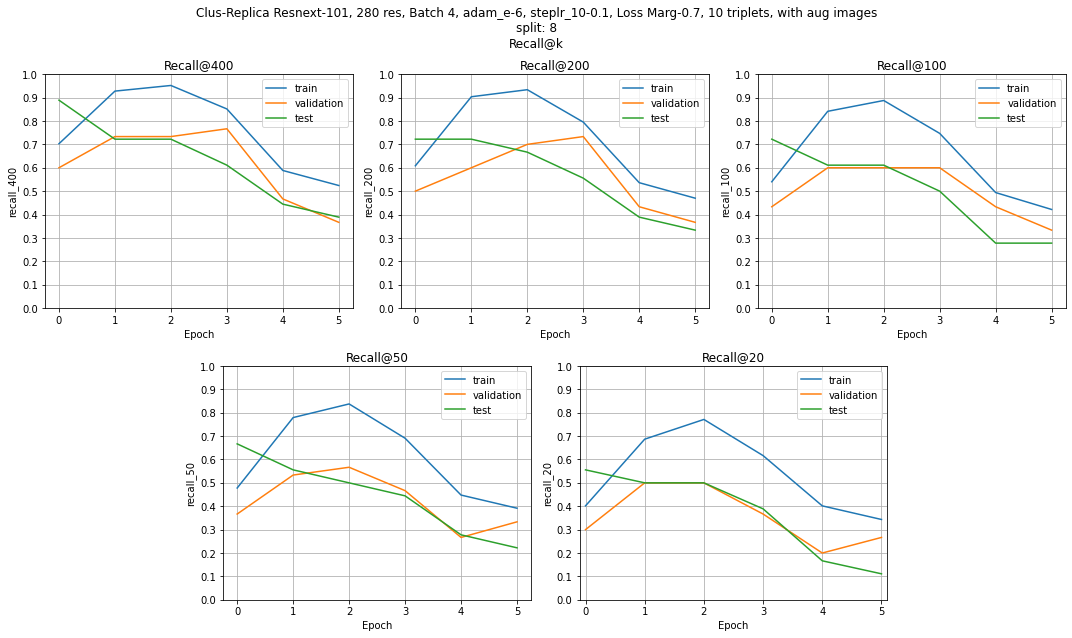

In [21]:
split_id = 8

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [22]:
best_epoch = 2

train_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v9

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,703.680000,857.541667,643.953125,0.206673,0.661458,0.567708,0.513889,0.442708,0.364583
1,323.350000,193.843750,293.802083,0.474688,0.890625,0.854167,0.812500,0.753472,0.682292
2,331.324167,252.359375,324.082465,0.462393,0.866319,0.810764,0.758681,0.710069,0.621528
3,687.120000,950.364583,678.673611,0.299574,0.631944,0.555556,0.498264,0.460069,0.406250
4,1074.029167,1729.973958,1074.146701,0.207741,0.468750,0.407986,0.373264,0.348958,0.303819


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,522.578947,645.157895,522.578947,0.342137,0.736842,0.631579,0.578947,0.578947,0.421053
1,380.605263,361.210526,380.605263,0.345145,0.789474,0.684211,0.631579,0.631579,0.578947
2,402.763158,405.526316,402.763158,0.299822,0.631579,0.631579,0.631579,0.578947,0.578947
3,546.394737,692.789474,546.394737,0.286618,0.736842,0.631579,0.526316,0.473684,0.421053
4,742.631579,1085.263158,742.631579,0.303222,0.736842,0.684211,0.473684,0.473684,0.368421


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,291.156250,182.312500,291.156250,0.393222,0.937500,0.812500,0.750000,0.687500,0.625000
1,292.000000,184.000000,292.000000,0.494492,0.937500,0.875000,0.875000,0.875000,0.812500
2,386.031250,372.062500,386.031250,0.569539,0.875000,0.812500,0.750000,0.687500,0.687500
3,792.250000,1184.500000,792.250000,0.137067,0.562500,0.375000,0.312500,0.187500,0.187500
4,1252.656250,2105.312500,1252.656250,0.081344,0.250000,0.187500,0.187500,0.187500,0.125000


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,416.785714,433.571429,416.785714,0.365490,0.828571,0.714286,0.657143,0.628571,0.514286
1,340.100000,280.200000,340.100000,0.413418,0.857143,0.771429,0.742857,0.742857,0.685714
2,395.114286,390.228571,395.114286,0.423121,0.742857,0.714286,0.685714,0.628571,0.628571
3,658.785714,917.571429,658.785714,0.218252,0.657143,0.514286,0.428571,0.342857,0.314286
4,975.785714,1551.571429,975.785714,0.201792,0.514286,0.457143,0.342857,0.342857,0.257143


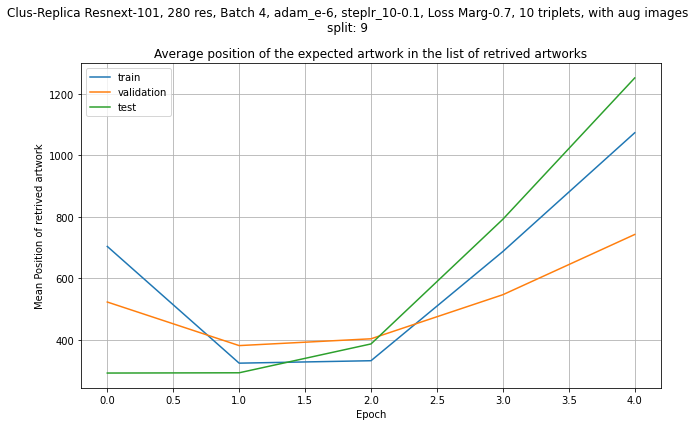

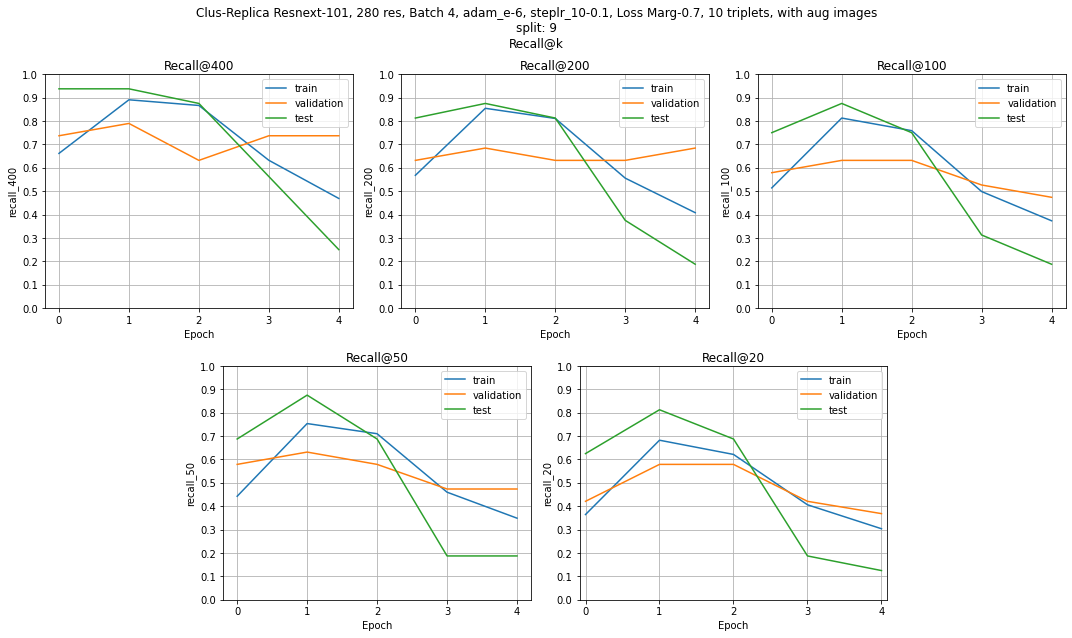

In [23]:
split_id = 9

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [24]:
best_epoch = 1

train_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v10

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,609.434211,698.568100,557.599462,0.203147,0.681004,0.578853,0.521505,0.446237,0.354839
1,285.422807,132.035842,267.582437,0.528766,0.912186,0.887097,0.854839,0.793907,0.715054
2,282.692982,148.111111,274.270609,0.567406,0.910394,0.881720,0.844086,0.790323,0.732975
3,772.550877,1089.060932,755.349462,0.344333,0.609319,0.559140,0.528674,0.492832,0.453405
4,1144.097368,1759.288530,1122.423835,0.212450,0.453405,0.406810,0.369176,0.340502,0.308244


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,606.979167,745.500000,572.113636,0.369118,0.772727,0.727273,0.636364,0.545455,0.454545
1,336.416667,303.181818,345.954545,0.351371,0.818182,0.772727,0.727273,0.636364,0.636364
2,483.062500,615.590909,509.295455,0.406078,0.727273,0.727273,0.681818,0.636364,0.590909
3,551.937500,739.409091,555.068182,0.316607,0.590909,0.545455,0.545455,0.454545,0.454545
4,1421.062500,1972.045455,1313.795455,0.182415,0.272727,0.272727,0.227273,0.227273,0.227273


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,511.000000,622.000000,511.000000,0.496119,0.750000,0.687500,0.687500,0.687500,0.625000
1,418.593750,437.187500,418.593750,0.387236,0.812500,0.750000,0.750000,0.687500,0.625000
2,495.531250,591.062500,495.531250,0.351770,0.812500,0.625000,0.625000,0.500000,0.500000
3,842.843750,1285.687500,842.843750,0.212589,0.687500,0.625000,0.437500,0.437500,0.312500
4,1364.156250,2328.312500,1364.156250,0.113237,0.312500,0.312500,0.250000,0.250000,0.250000


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,568.587500,693.500000,546.381579,0.422592,0.763158,0.710526,0.657895,0.605263,0.526316
1,369.287500,359.605263,376.539474,0.366472,0.815789,0.763158,0.736842,0.657895,0.631579
2,488.050000,605.263158,503.500000,0.383211,0.763158,0.684211,0.657895,0.578947,0.552632
3,668.300000,969.421053,676.236842,0.272810,0.631579,0.578947,0.500000,0.447368,0.394737
4,1398.300000,2122.052632,1335.000000,0.153288,0.289474,0.289474,0.236842,0.236842,0.236842


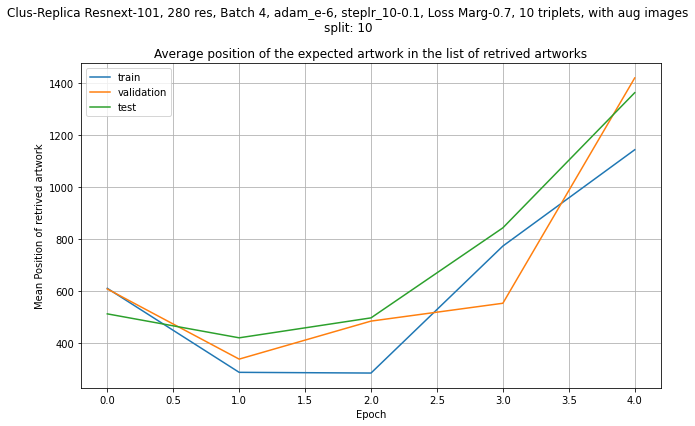

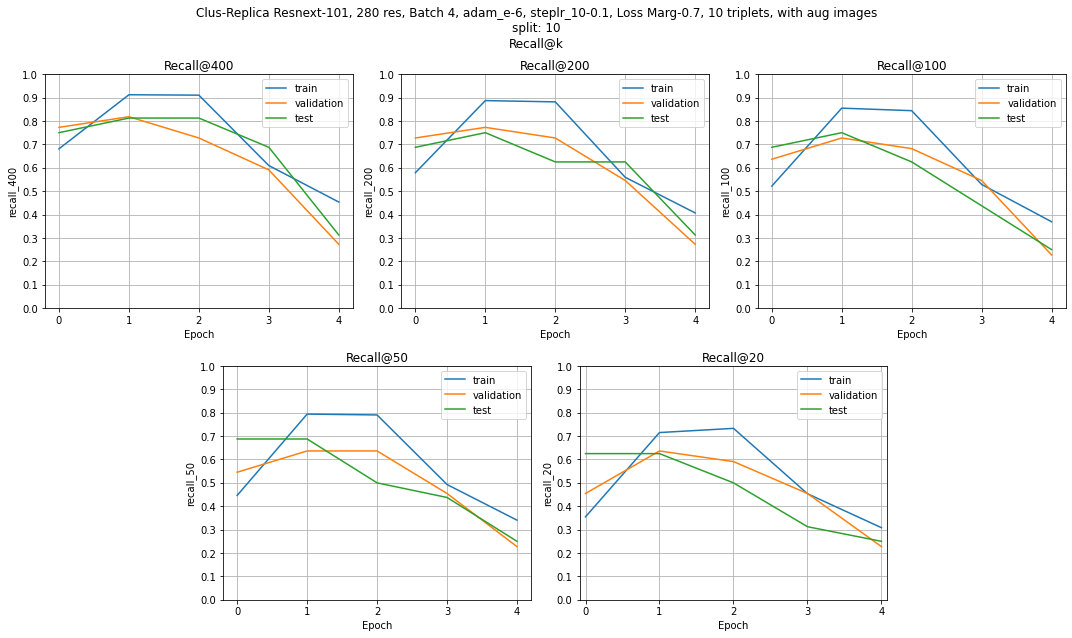

In [25]:
split_id = 10

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [26]:
best_epoch = 1

train_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT Aug Clus-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

In [27]:
train_metrics_df = pd.DataFrame(train_metrics, columns=["model", "data_split_version", "best_epoch", "MP","MMP", "mean_median_position", 'MAP','R@400', 'R@200', 'R@100', 'R@50', 'R@20'])
val_metrics_df = pd.DataFrame(val_metrics, columns=["model", "data_split_version", "best_epoch", "MP","MMP", "mean_median_position", 'MAP','R@400', 'R@200', 'R@100', 'R@50', 'R@20'])
test_metrics_df = pd.DataFrame(test_metrics, columns=["model", "data_split_version", "best_epoch", "MP","MMP", "mean_median_position", 'MAP','R@400', 'R@200', 'R@100', 'R@50', 'R@20'])
non_train_metrics_df = pd.DataFrame(non_train_metrics, columns=["model", "data_split_version", "best_epoch", "MP","MMP", "mean_median_position", 'MAP','R@400', 'R@200', 'R@100', 'R@50', 'R@20'])

In [28]:
train_metrics_df["MAP"] = 100 * train_metrics_df["MAP"]
train_metrics_df["R@400"] = 100 * train_metrics_df["R@400"]
train_metrics_df["R@200"] = 100 * train_metrics_df["R@200"]
train_metrics_df["R@100"] = 100 * train_metrics_df["R@100"]
train_metrics_df["R@50"] = 100 * train_metrics_df["R@50"]
train_metrics_df["R@20"] = 100 * train_metrics_df["R@20"]

val_metrics_df["MAP"] = 100 * val_metrics_df["MAP"]
val_metrics_df["R@400"] = 100 * val_metrics_df["R@400"]
val_metrics_df["R@200"] = 100 * val_metrics_df["R@200"]
val_metrics_df["R@100"] = 100 * val_metrics_df["R@100"]
val_metrics_df["R@50"] = 100 * val_metrics_df["R@50"]
val_metrics_df["R@20"] = 100 * val_metrics_df["R@20"]

test_metrics_df["MAP"] = 100 * test_metrics_df["MAP"]
test_metrics_df["R@400"] = 100 * test_metrics_df["R@400"]
test_metrics_df["R@200"] = 100 * test_metrics_df["R@200"]
test_metrics_df["R@100"] = 100 * test_metrics_df["R@100"]
test_metrics_df["R@50"] = 100 * test_metrics_df["R@50"]
test_metrics_df["R@20"] = 100 * test_metrics_df["R@20"]

non_train_metrics_df["MAP"] = 100 * non_train_metrics_df["MAP"]
non_train_metrics_df["R@400"] = 100 * non_train_metrics_df["R@400"]
non_train_metrics_df["R@200"] = 100 * non_train_metrics_df["R@200"]
non_train_metrics_df["R@100"] = 100 * non_train_metrics_df["R@100"]
non_train_metrics_df["R@50"] = 100 * non_train_metrics_df["R@50"]
non_train_metrics_df["R@20"] = 100 * non_train_metrics_df["R@20"]

In [29]:
train_metrics_df

,model,data_split_version,best_epoch,MP,MMP,mean_median_position,MAP,R@400,R@200,R@100,R@50,R@20
0,FT Aug Clus-Replica,0,2,315.133333,226.193548,314.129032,48.917545,89.964158,84.587814,79.569892,72.401434,63.620072
1,FT Aug Clus-Replica,1,1,311.102183,186.847917,289.669792,43.688066,88.333333,83.541667,81.250000,75.000000,63.958333
2,FT Aug Clus-Replica,2,1,277.041176,135.000000,264.313008,51.880433,91.869919,88.211382,85.162602,79.471545,71.747967
3,FT Aug Clus-Replica,3,2,234.997863,75.878788,232.963203,65.753592,96.536797,93.506494,90.692641,87.012987,82.034632
4,FT Aug Clus-Replica,4,2,281.620482,131.666667,266.524691,55.051308,91.563786,88.888889,84.979424,79.835391,74.074074
5,FT Aug Clus-Replica,5,2,281.952519,148.074297,269.201807,49.499640,90.562249,86.746988,82.128514,77.510040,69.879518
6,FT Aug Clus-Replica,6,1,305.751016,213.927083,301.236458,51.872200,90.208333,87.083333,82.500000,76.666667,70.625000
7,FT Aug Clus-Replica,7,2,257.672807,124.754480,255.327061,57.456350,93.548387,91.218638,88.351254,85.304659,77.598566
8,FT Aug Clus-Replica,8,2,236.641473,86.622490,231.485944,56.125378,95.180723,93.373494,88.755020,83.734940,77.108434
9,FT Aug Clus-Replica,9,1,323.350000,193.843750,293.802083,47.468764,89.062500,85.416667,81.250000,75.347222,68.229167


In [30]:
val_metrics_df

,model,data_split_version,best_epoch,MP,MMP,mean_median_position,MAP,R@400,R@200,R@100,R@50,R@20
0,FT Aug Clus-Replica,0,2,321.425000,276.263158,317.447368,37.698226,73.684211,73.684211,73.684211,73.684211,63.157895
1,FT Aug Clus-Replica,1,1,400.083333,400.166667,400.083333,25.075146,83.333333,76.666667,66.666667,63.333333,40.000000
2,FT Aug Clus-Replica,2,1,508.340909,616.681818,508.340909,35.242607,77.272727,72.727273,63.636364,54.545455,45.454545
3,FT Aug Clus-Replica,3,2,362.600000,341.517241,365.275862,17.508673,75.862069,72.413793,62.068966,48.275862,37.931034
4,FT Aug Clus-Replica,4,2,447.693548,478.700000,452.650000,21.832137,76.666667,66.666667,66.666667,43.333333,36.666667
5,FT Aug Clus-Replica,5,2,346.396552,292.793103,346.396552,34.350876,82.758621,75.862069,72.413793,68.965517,62.068966
6,FT Aug Clus-Replica,6,1,557.975000,208.166667,305.805556,37.169916,72.222222,66.666667,61.111111,61.111111,50.000000
7,FT Aug Clus-Replica,7,2,589.157895,778.315789,589.157895,29.137282,68.421053,57.894737,57.894737,47.368421,42.105263
8,FT Aug Clus-Replica,8,2,527.080645,372.633333,399.550000,29.271376,73.333333,70.000000,60.000000,56.666667,50.000000
9,FT Aug Clus-Replica,9,1,380.605263,361.210526,380.605263,34.514505,78.947368,68.421053,63.157895,63.157895,57.894737


In [31]:
test_metrics_df

,model,data_split_version,best_epoch,MP,MMP,mean_median_position,MAP,R@400,R@200,R@100,R@50,R@20
0,FT Aug Clus-Replica,0,2,320.450000,128.736842,285.368421,34.845346,78.947368,78.947368,68.421053,68.421053,52.631579
1,FT Aug Clus-Replica,1,1,466.190476,532.380952,466.190476,37.842432,76.190476,71.428571,71.428571,66.666667,57.142857
2,FT Aug Clus-Replica,2,1,386.071429,374.592593,398.555556,19.551087,74.074074,66.666667,59.259259,55.555556,44.444444
3,FT Aug Clus-Replica,3,2,689.833333,521.320000,475.900000,37.671019,88.000000,76.000000,64.000000,60.000000,52.000000
4,FT Aug Clus-Replica,4,2,405.428571,440.300000,409.400000,33.094977,75.000000,75.000000,65.000000,60.000000,40.000000
5,FT Aug Clus-Replica,5,2,265.675000,154.473684,260.815789,47.586172,84.210526,73.684211,73.684211,73.684211,63.157895
6,FT Aug Clus-Replica,6,1,479.984848,559.969697,479.984848,30.674203,78.787879,69.696970,63.636364,60.606061,45.454545
7,FT Aug Clus-Replica,7,2,750.571429,857.894737,647.473684,29.466480,73.684211,73.684211,68.421053,57.894737,47.368421
8,FT Aug Clus-Replica,8,2,468.833333,537.666667,468.833333,23.797355,72.222222,66.666667,61.111111,50.000000,50.000000
9,FT Aug Clus-Replica,9,1,292.000000,184.000000,292.000000,49.449200,93.750000,87.500000,87.500000,87.500000,81.250000


In [32]:
non_train_metrics_df

,model,data_split_version,best_epoch,MP,MMP,mean_median_position,MAP,R@400,R@200,R@100,R@50,R@20
0,FT Aug Clus-Replica,0,2,320.937500,202.500000,301.407895,36.271786,76.315789,76.315789,71.052632,71.052632,57.894737
1,FT Aug Clus-Replica,1,1,427.303922,454.607843,427.303922,30.332264,80.392157,74.509804,68.627451,64.705882,47.058824
2,FT Aug Clus-Replica,2,1,439.870000,483.285714,447.846939,26.596259,75.510204,69.387755,61.224490,55.102041,44.897959
3,FT Aug Clus-Replica,3,2,517.605263,424.759259,416.490741,26.843093,81.481481,74.074074,62.962963,53.703704,44.444444
4,FT Aug Clus-Replica,4,2,430.625000,463.340000,435.350000,26.337273,76.000000,70.000000,66.000000,50.000000,38.000000
5,FT Aug Clus-Replica,5,2,313.448980,238.041667,312.520833,39.589847,83.333333,75.000000,72.916667,70.833333,62.500000
6,FT Aug Clus-Replica,6,1,509.415094,435.803922,418.509804,32.966808,76.470588,68.627451,62.745098,60.784314,47.058824
7,FT Aug Clus-Replica,7,2,673.900000,818.105263,618.315789,29.301881,71.052632,65.789474,63.157895,52.631579,44.736842
8,FT Aug Clus-Replica,8,2,505.683673,434.520833,425.531250,27.218618,72.916667,68.750000,60.416667,54.166667,50.000000
9,FT Aug Clus-Replica,9,1,340.100000,280.200000,340.100000,41.341794,85.714286,77.142857,74.285714,74.285714,68.571429


In [33]:
train_metrics_df.to_csv("./../../../data/model_learning/comparison/scores/fine_tune_clusreplica_aug/train_scores_kfold.csv", index=False)
val_metrics_df.to_csv("./../../../data/model_learning/comparison/scores/fine_tune_clusreplica_aug/val_scores_kfold.csv", index=False)
test_metrics_df.to_csv("./../../../data/model_learning/comparison/scores/fine_tune_clusreplica_aug/test_scores_kfold.csv", index=False)
non_train_metrics_df.to_csv("./../../../data/model_learning/comparison/scores/fine_tune_clusreplica_aug/non_train_scores_kfold.csv", index=False)

In [3]:
train_metrics_df= pd.read_csv("./../../../data/model_learning/comparison/scores/fine_tune_clusreplica_aug/train_scores_kfold.csv")
val_metrics_df = pd.read_csv("./../../../data/model_learning/comparison/scores/fine_tune_clusreplica_aug/val_scores_kfold.csv")
test_metrics_df = pd.read_csv("./../../../data/model_learning/comparison/scores/fine_tune_clusreplica_aug/test_scores_kfold.csv")
non_train_metrics_df = pd.read_csv("./../../../data/model_learning/comparison/scores/fine_tune_clusreplica_aug/non_train_scores_kfold.csv")

In [4]:
get_averaged_df(train_metrics_df)

,model,MP,MMP,MAP,R@400,R@200,R@100,R@50,R@20
0,FT Aug Clus-Replica,282.79 ± 30.18,150.44 ± 49.2,52.78 ± 5.87,91.64 ± 2.53,88.3 ± 3.32,84.56 ± 3.58,79.24 ± 4.55,71.85 ± 5.64


In [5]:
get_averaged_df(val_metrics_df)

,model,MP,MMP,MAP,R@400,R@200,R@100,R@50,R@20
0,FT Aug Clus-Replica,434.34 ± 96.33,402.69 ± 165.78,30.63 ± 6.69,76.76 ± 4.71,70.75 ± 5.69,65.46 ± 5.46,58.55 ± 9.46,49.9 ± 10.36


In [6]:
get_averaged_df(test_metrics_df)

,model,MP,MMP,MAP,R@400,R@200,R@100,R@50,R@20
0,FT Aug Clus-Replica,449.42 ± 152.37,429.87 ± 214.67,34.79 ± 9.02,79.65 ± 6.7,74.02 ± 5.88,68.86 ± 7.96,64.46 ± 10.2,54.18 ± 11.55


In [7]:
get_averaged_df(non_train_metrics_df)

,model,MP,MMP,MAP,R@400,R@200,R@100,R@50,R@20
0,FT Aug Clus-Replica,440.74 ± 107.37,417.71 ± 164.2,32.13 ± 5.53,78.25 ± 4.55,72.36 ± 3.91,67.01 ± 5.28,61.19 ± 8.58,51.67 ± 9.76
